# Vasicek model: simulation and calibration

## Mathematics

The Vasicek model is a simple interest rates model. The model states that the instantaneous interest rate follows a (mean-reverting)  Ornstein-Uhlenbeck (OU) process described by the stochastic differential equation (SDE)

\begin{equation}
    dr_t = \kappa(\theta - r_t)dt + \sigma dW_t
\end{equation}

where $r_t$ is the interest rate at time $t$, $\kappa \in \mathbb{R}^+$ is the mean-reversion speed, $\theta \in \mathbb{R}$ is the long-run mean level, $\sigma \in \mathbb{R}^+$ is the interest rate volatility and $W_t$ is a Wiener process (i.e. Brownian motion).

Let's solve this SDE. Let $u_t = r_t - \theta$, $du_t = dr_t$ and we have

\begin{equation*}
    \begin{gathered}
        du_t = -\kappa u_t dt + \sigma dW_t \\[7pt]
        du_t + \kappa u_t dt = \sigma dW_t \\[7pt]
        e^{\kappa t} (du_t + \kappa u_t dt) = e^{\kappa t} \sigma dW_t \\[7pt]
        d(e^{\kappa t} u_t) = e^{\kappa t} \sigma dW_t \\[5pt]
        \int_s^t d(e^{\kappa \tau} u_{\tau}) = \sigma \int_s^t e^{\kappa \tau} dW_{\tau} \\
        e^{\kappa t} u_t - e^{\kappa s} u_s = \sigma \int_s^t e^{\kappa \tau} dW_{\tau} \\
        e^{\kappa t} u_t = u_s e^{\kappa s} + \sigma \int_s^t e^{\kappa \tau} dW_{\tau} \\
        u_t = u_s e^{-\kappa (t-s)} + \sigma \int_s^t e^{-\kappa (t - \tau)} dW_{\tau} \\
        r_t - \theta = (r_s - \theta) e^{-\kappa (t-s)} + \sigma \int_s^t e^{-\kappa (t - \tau)} dW_{\tau} \;\;.
    \end{gathered}
\end{equation*}

Finally, we can write the solution of the SDE as

\begin{equation}
    r_t  = r_se^{-\kappa (t-s)} + \theta(1 - e^{-\kappa (t-s)}) + \sigma \int_s^t e^{-\kappa (t - \tau)} dW_{\tau} \;\;.
\end{equation}

The process $r_t$ is Gaussian with

\begin{equation}
    r_t \sim \mathcal{N}\big(\mathbb{E}[r_t  \mid r_s], \mathbb{V}[r_t \mid r_s]\big)
\end{equation}

where 

\begin{equation}
    \mathbb{E}[r_t  \mid r_s] = r_se^{-\kappa (t-s)} + \theta(1 - e^{-\kappa (t-s)})
\end{equation}

because the integral is an Itô integral (i.e. a martingale) and

\begin{equation}
    \mathbb{V}[r_t \mid r_s] =  \mathbb{V}\left[\sigma \int_s^t e^{-\kappa (t - \tau)} dW_{\tau}\right] = \sigma^2 \int_s^t e^{-2\kappa (t - \tau)} d\tau = \frac{\sigma^2}{2 \kappa} (1 - e^{-2\kappa (t - s)}).
\end{equation}

Note that we can compute the variance with respect to the integral only because the rest is a scalar with zero variance. Also, note that we used the Itô isometry property to compute the variance.

## Simulation

We can now use these analytic moments to simulate interest rate paths. Let's define some parameters and use them to generate sample paths.

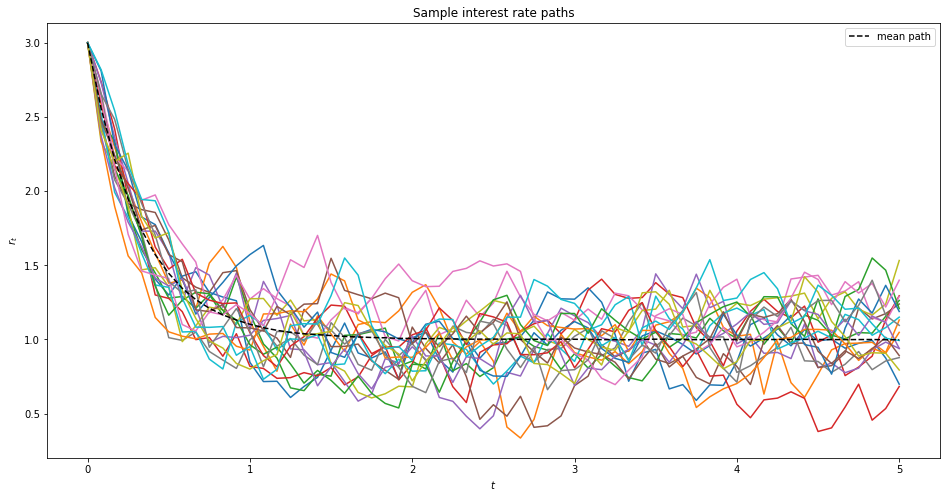

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm

# Parameters and time grid
npaths = 20000 # number of paths
T = 5 # time horizon
nsteps = 60 # number of time steps
dt = T/nsteps # time step
t = np.linspace(0, T, nsteps+1) # observation times
npathsplot = 20 # number of paths ploted
kappa = 3 # reversion rate
theta = 1 # long term mean
sigma = 0.5 # volatility
r0 = 3 # initial value

# Initialize array
r = np.concatenate((r0*np.ones((npaths, 1)), np.zeros((npaths, nsteps))), axis=1)

# Sample standard Gaussian random numbers
N = np.random.normal(size=(npaths, nsteps))

# Standard deviation for a time step (Euler with analytic moments)
sdev = sigma*np.sqrt((1-np.exp(-2*kappa*dt))/(2*kappa))

# Compute and accumulate the increments (Euler with analytic moments)
for i in range(nsteps):
    r[:, i+1] = theta+(r[:, i]-theta)*np.exp(-kappa*dt) + sdev*N[:, i]

# Plot sample paths
fig = plt.figure(figsize=(16,8)) 
ax = fig.add_subplot(111)
for i in range(0, npaths, round(npaths/npathsplot)):
    ax.plot(t, r[i,:])
ax.plot(t, np.mean(r, axis=0), 'k--', label='mean path') # mean path
ax.set_title('Sample interest rate paths')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$r_t$')
ax.legend();


Let's plot the distribution of $r_T$ (at time $t = T$). As $r_T$ should be normally distributed, we also fit a normal distribution. This will allow us to compare the expected mean and standard deviation to the fitted ones.

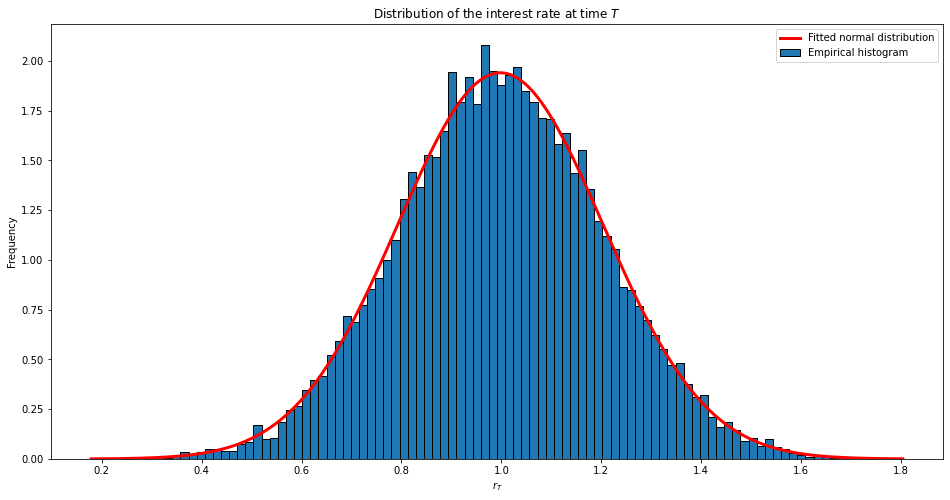

In [2]:
# Plot the distribution of the interest rate at T
fig = plt.figure(figsize=(16, 8)) 
ax = fig.add_subplot(111)
ax.hist(r[:,-1], 100, density=True, ec='k', label='Empirical histogram')
ax.set_title(r'Distribution of the interest rate at time $T$')
ax.set_xlabel(r'$r_T$')
ax.set_ylabel('Frequency')

# Fit a normal distribution
r_grid = np.linspace(r[:,-1].min(), r[:,-1].max(), 1000)
params= st.norm.fit(r[:,-1])
pdf = st.norm.pdf(r_grid, *params)
ax.plot(r_grid, pdf, 'r', lw=3, label='Fitted normal distribution')
ax.legend();

Let's compare the mean and standard deviation predicted by the theory and those obtained by fitting the normal distribution.

In [3]:
theoretical_mean = theta+(r0-theta)*np.exp(-kappa*T)
theoretical_std = np.sqrt((sigma**2)/(2*kappa))*(1-np.exp(-2*kappa*T))

fitted_mean = params[0]
fitted_std = params[1]

print('The theoretical mean is ' + str(np.round(theoretical_mean, 5)))
print('The fitted mean is ' + str(np.round(fitted_mean, 5)))
print('The theoretical standard deviation is ' + str(np.round(theoretical_std, 5)))
print('The fitted standard deviation is ' + str(np.round(fitted_std, 5)))


The theoretical mean is 1.0
The fitted mean is 0.99798
The theoretical standard deviation is 0.20412
The fitted standard deviation is 0.20557


As expected, the fitted values for the expectation and variance are very close to those predicted by the theory.

## Calibration

Let's use the first sample path that was generated to calibrate our parameters. We will do so using two methods:
- Least Squares Regression,
- Maximum Likelihood Estimation.

### Least squares regression

First, let's do the calibration task without using a specific package for the linear regression.

In [4]:
# Calibration of first sample path via Least Squares Regression
def ou_calibration_ls(X, dt):
    
    n = len(X)-1    
    Sx = np.sum(X[:-1])
    Sy = np.sum(X[1:])
    Sxx = np.sum(np.power(X[:-1], 2))
    Syy = np.sum(np.power(X[1:], 2))
    Sxy = np.sum(np.multiply(X[:-1], X[1:]))

    a = (n*Sxy - Sx*Sy) / (n*Sxx - Sx**2)
    b = (Sy - a*Sx) / n
    sd2 = (n*Syy - Sy**2 - a*(n*Sxy - Sx*Sy)) / (n*(n-2))
    
    theta = b/(1-a)
    kappa = -np.log(a)/dt
    sigma = np.sqrt(sd2*2*kappa/(1-a**2))

    return theta, sigma, kappa

theta_LS, sigma_LS, kappa_LS = ou_calibration_ls(r[0,:], dt)

print('kappa = ' + str(np.round(kappa_LS, 4)))
print('theta = ' + str(np.round(theta_LS, 4)))
print('sigma = ' + str(np.round(sigma_LS, 4)))

kappa = 3.1212
theta = 0.9249
sigma = 0.5273


To show that it works, let's calibrate the parameters using a standard package for linear regression. We will see that it yields the same calibrated parameters.

In [5]:
# Calibration via Least Squares Regression using sm package
y = r[0,:][1:]
X = r[0,:][:-1].reshape((-1, 1))

model = sm.OLS(y, sm.add_constant(X)).fit()
a = model.params[1] # slope
b = model.params[0] # intercept
std_resid = np.std(model.resid, ddof=2) # standard deviation of residuals (2 degrees of freedom)

kappa_ls_sm = -np.log(a)/dt
theta_ls_sm = b / (1 - a)
sigma_ls_sm = std_resid*np.sqrt((-2*np.log(a))/(dt*(1-a**2)))

print('kappa = ' + str(np.round(kappa_ls_sm, 4)))
print('theta = ' + str(np.round(theta_ls_sm, 4)))
print('sigma = ' + str(np.round(sigma_ls_sm, 4)))

kappa = 3.1212
theta = 0.9249
sigma = 0.5273


### Maximum likelihood estimation

Finally, let's calibrate our parameters using MLE.

In [6]:
# Calibration of first sample path via Maximum Likelihood Estimation
def ou_calibration_ml(X, dt):

    n = len(X)-1    
    Sx = np.sum(X[:-1])
    Sy = np.sum(X[1:])
    Sxx = np.sum(np.power(X[:-1], 2))
    Syy = np.sum(np.power(X[1:], 2))
    Sxy = np.sum(np.multiply(X[:-1], X[1:]))
    
    theta = (Sy*Sxx - Sx*Sxy) / (n*(Sxx - Sxy) - Sx**2 + Sx*Sy)
    a = (Sxy - theta*Sx - theta*Sy + n*theta**2)/(Sxx - 2*theta*Sx + n*theta**2)
    sigmah2 = (Syy - 2*a*Sxy + a**2*Sxx - 2*theta*(1-a)*(Sy - a*Sx) + n*theta**2*(1-a)**2)/n
    kappa = -np.log(a)/dt
    sigma = np.sqrt(sigmah2*2*kappa/(1-a**2))
    
    return theta, sigma, kappa

theta_ML, sigma_ML, kappa_ML = ou_calibration_ml(r[0,:], dt)

print('kappa = ' + str(np.round(kappa_ML, 4)))
print('theta = ' + str(np.round(theta_ML, 4)))
print('sigma = ' + str(np.round(sigma_ML, 4)))

kappa = 3.1212
theta = 0.9249
sigma = 0.5184


We can see that the calibrated parameters are similar with the different methods. Only sigma is different. The difference is due to the fact that two degrees of freedom are used in the least squares computation. We can recover the LS value of sigma by dividing by ```n - 2``` instead of ```n``` when computing ```sigmah2``` in the ML script. Similarly, the ML value of sigma is recovered by using 0 degrees of freedom when computing the standard deviation of the residuals in the LS method.

The fitted parameters are also quite similar to the parameters that were actually used to generate the sample paths.